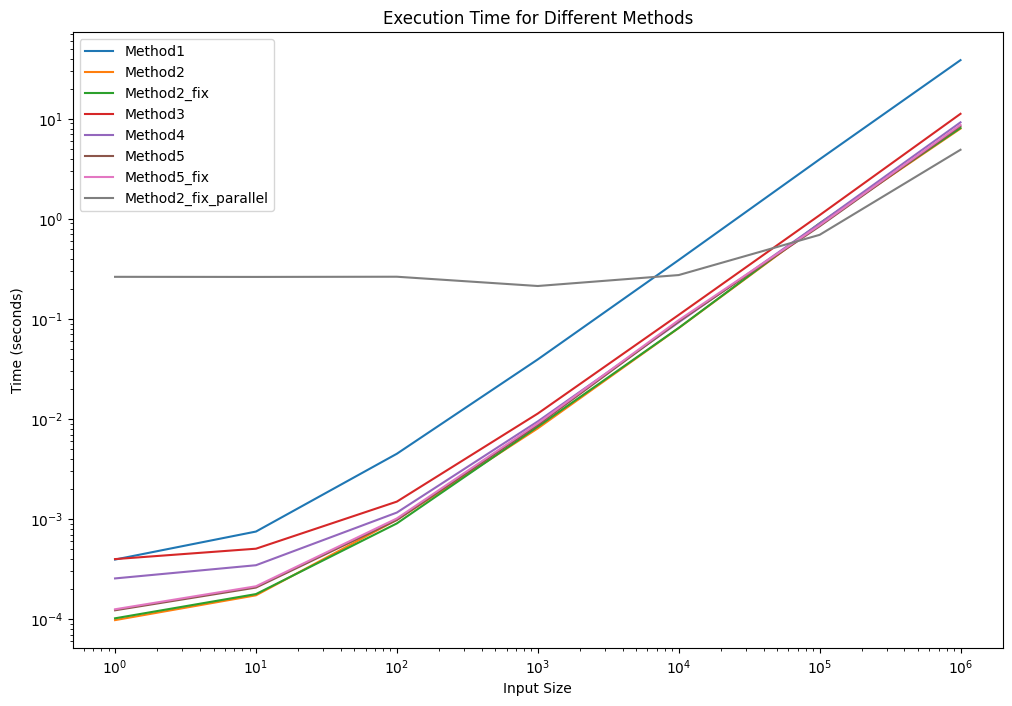

In [56]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from numpy.lib import recfunctions as rfn

# Here we define our input and output data schemas
# For a simulation, the number of samples can vary, so each data type is a sample of a particular variable
InputDataTypeSchema = np.dtype([(col, np.float64) for col in list("ABCDE")])
OutputDataTypeSchema = np.dtype([(col, np.float64) for col in list("FGHIJKLMNOPQ")])
# And their respective data types, as numpy arrays
NpInputDataType = NDArray[InputDataTypeSchema]  # type: ignore
NpOutputDataType = NDArray[OutputDataTypeSchema]  # type: ignore

PdInputDataType = pd.DataFrame
PdOutputDataType = pd.DataFrame

class Method1:
    @staticmethod
    def fun(data: NpInputDataType) -> NpOutputDataType:
        return rfn.unstructured_to_structured(
            (
                np.random.rand(
                    len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
                )
                * [data[col] ** k for k, col in enumerate(InputDataTypeSchema.names)]
            ).sum(axis=1),
            dtype=OutputDataTypeSchema,
        )

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_records(index=False)

        res: NpOutputDataType = rfn.unstructured_to_structured(
            np.empty(shape=(
                len(data), len(OutputDataTypeSchema.names)
            )), dtype=OutputDataTypeSchema
        )

        for k, sample in enumerate(data):
            res[k] = Method1.fun(sample)

        return pd.DataFrame.from_records(res)


class Method2:
    @staticmethod
    def fun(data):
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            # big warning here: the column order is not garanteed, so we would
            # need a loopkup table to do the conversion between column name to 
            # column number
            * [data[k] ** k for k, _ in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_numpy()

        res = np.empty(shape=(
            len(data), len(OutputDataTypeSchema.names)
        ))

        for k, sample in enumerate(data):
            res[k] = Method2.fun(sample)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)

class Method2_fix:
    @staticmethod
    def fun(data, cols):
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[cols[col]] ** k for k, col in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_numpy()

        # Here we generate the mapping between column name and number
        cols = {v: k for k, v in dict(enumerate(df.columns)).items()}

        res = np.empty(shape=(
            len(data), len(OutputDataTypeSchema.names)
        ))

        for k, sample in enumerate(data):
            res[k] = Method2_fix.fun(sample, cols)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)


class Method3:
    @staticmethod
    def fun(data: dict) -> NDArray[np.float64]:
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[col] ** k for k, col in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_dict('records')  # list of dicts

        res: list[NDArray[np.float64]] = []

        for sample in data:
            res.append(Method3.fun(sample))

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)


class Method4:
    @staticmethod
    def fun(data: dict) -> NDArray[np.float64]:
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[col] ** k for k, col in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_dict('records')  # list of dicts

        res = np.empty(shape=(
            len(data), len(OutputDataTypeSchema.names)
        ))

        for k, sample in enumerate(data):
            res[k] = Method4.fun(sample)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)

class Method5:
    @staticmethod
    def fun(data):
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[k] ** k for k, _ in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_numpy()

        res = np.apply_along_axis(Method5.fun, 1, data)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)

class Method5_fix:
    @staticmethod
    def fun(data, cols):
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[cols[col]] ** k for k, col in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_numpy()

        # Here we generate the mapping between column name and number
        cols = {v: k for k, v in dict(enumerate(df.columns)).items()}

        res = np.apply_along_axis(Method5_fix.fun, 1, data, cols=cols)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)


from multiprocessing import Pool

class Method2_fix_parallel:
    @staticmethod
    def fun(x):
        data, cols = x
        return (
            np.random.rand(
                len(OutputDataTypeSchema.names), len(InputDataTypeSchema.names)
            )
            * [data[cols[col]] ** k for k, col in enumerate(InputDataTypeSchema.names)]
        ).sum(axis=1)

    @staticmethod
    def runner(df: PdInputDataType) -> PdOutputDataType:
        data = df.to_numpy()

        # Here we generate the mapping between column name and number
        cols = {v: k for k, v in dict(enumerate(df.columns)).items()}

        res = np.empty(shape=(
            len(data), len(OutputDataTypeSchema.names)
        ))

        with Pool() as pool:
            results = pool.map(Method2_fix_parallel.fun, [(sample, cols) for sample in data])
            res = np.vstack(results)

        return pd.DataFrame(res, columns=OutputDataTypeSchema.names)


import matplotlib.pyplot as plt


methods = [
    Method1,
    Method2,
    Method2_fix,
    Method3,
    Method4,
    Method5,
    Method5_fix,
    Method2_fix_parallel,
]
sizes = [1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]

timings = {method.__name__: {size: [] for size in sizes } for method in methods}
for size in sizes:
    # Let's define our input data
    input_data: PdInputDataType = pd.DataFrame(rfn.unstructured_to_structured(
        np.random.rand(size, len(InputDataTypeSchema.names)), dtype=InputDataTypeSchema
    ))

    for method in methods:
        t = %timeit -o -q -r 7 method.runner(input_data)
        timings[method.__name__][size] = t.best


df = pd.DataFrame(timings)
display(df)

df.plot(figsize=(12, 8))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Input Size')
plt.ylabel('Time (seconds)')
plt.title('Execution Time for Different Methods')
plt.legend()
plt.show()

NameError: name 'timings' is not defined